# Кластеризация.

[Кластеризация](https://ru.wikipedia.org/wiki/%D0%9A%D0%BB%D0%B0%D1%81%D1%82%D0%B5%D1%80%D0%BD%D1%8B%D0%B9_%D0%B0%D0%BD%D0%B0%D0%BB%D0%B8%D0%B7) - это один из видов задач обучения без учителя. Задача заключается в разбиении всех объектов на группы похожих между собой объектов и сильно отличающихся от всех остальных. Так как строгого понятия похожести объектов как такового нет, то алгоритмов кластеризации много, да и каждый алгоритм имеет много вариантов работы.

![](http://scikit-learn.org/stable/_images/sphx_glr_plot_cluster_comparison_0011.png)

## KMeans

Метод k-means - это один из наиболее популярных методов кластеризации. Основная идея метода заключается в том, что на каждой итерации пересчитывается центр масс (центроид) для каждого кластера, полученного на предыдущем шаге, затем объекты снова разбиваются на кластеры согласно тому, какой из новых центроидов находится ближе.
Более формально, алгоритм принимает на вход выборку $X_1, \dots, X_N$ и параметр $k$, указывающий необходимое число кластеров. Выходом алгоритма является набор из $k$ центроидов $\{\mu_1, \dots, \mu_k\}$, с помощью которых кластеризация осуществляется путём отнесения каждого объекту к ближайшему центроиду. Все точки внутри одного кластера ближе к центроиду этого кластера, чем к центроиду любого другого кластера.
Метод может быть сформулирован как задача оптимизации, а именно, минимизации суммарного квадратичного отклонения точек кластеров от центров этих кластеров по центроидам и кластерам: $$\sum_{i=1}^k \sum_{X_n \in C_i} ||X_n - \mu_i||^2 \rightarrow \min, \text{где $C_i$ - это $i$-ый кластер, $\mu_i$ - это центр масс кластера $C_i$.}$$
Решение такой задачи оптимизации является NP-трудной задачей, однако существует простой итеративный алгоритм, позволяющий найти локальный минимум указанного функционала. Алгоритм представляет собой последовательное чередование двух шагов до сходимости.
Предположим, что как-то (например, случайно) выбраны начальные положения центроидов $\mu_1, \dots, \mu_k$.

1. Этап кластеризациu. На данном этапе происходит кластеризация выборки, как было описано выше: каждый объект относится к кластеру ближайшего к нему центроида. Формально, $$C_i = \{X_n : ||X_n - \mu_i|| \leq ||X_n - \mu_j||, \text{ для всех $j \in \{1, \dots, k\}$}\}.$$

2. Этап обновления центроидов. На данном этапе центроиды пересчитываются, как центры масс только что построенных кластеров. Формально, $$\mu_i = \frac{1}{|C_i|}\sum_{X_n \in C_i} X_n.$$

Этот процесс продолжается, пока центроиды и кластеризация продолжают изменяться. Алгоритм гарантированно сходится, однако не гарантируется достижение глобального минимума, а только одного из локальных минимумов. Другим недостатком алгоритма является то, что итоговая кластеризация зависит от выбора исходных центров кластеров. На практике алгоритм запускается несколько раз из различных начальных приближений, а полученные результаты некоторым образом усредняются. Стоит также отметить, что число кластеров необходимо знать заранее. Существуют различные эвристики, позволяющие выбирать в некотором смысле оптимальное число кластеров.

_определение взято из материалов курса [ODS](https://habrahabr.ru/company/ods/)_

### Литература

- [ODS: Обучение без учителя: PCA и кластеризация](https://habrahabr.ru/company/ods/blog/325654/)
- [Интересные алгоритмы кластеризации, часть первая: Affinity propagation](https://habrahabr.ru/post/321216/) и другие статьи цикла
- [Глава 7: кластеризация и визуализация. К. В. Воронцов](http://www.machinelearning.ru/wiki/images/6/6d/Voron-ML-1.pdf)
- [Документация sklearn.clustering](http://scikit-learn.org/stable/modules/clustering.html)
- [K-Means Clustering - The Math of Intelligence. Siraj Raval](https://www.youtube.com/watch?v=9991JlKnFmk) объяснение с программированием KMeans вручную

In [116]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import random 
from tqdm.notebook import tqdm
from skimage.io import imread

%matplotlib inline

# Зафиксируем случайность, чтобы у нас получались одинаковые результаты.
np.random.seed(seed=42)

## Рассмотрим как работает алгоритм кластеризации KMeans на синтетическом примере.

Бросим на плоскость случайно точки с разными параметрами случайности, чтобы образовались кластеры.

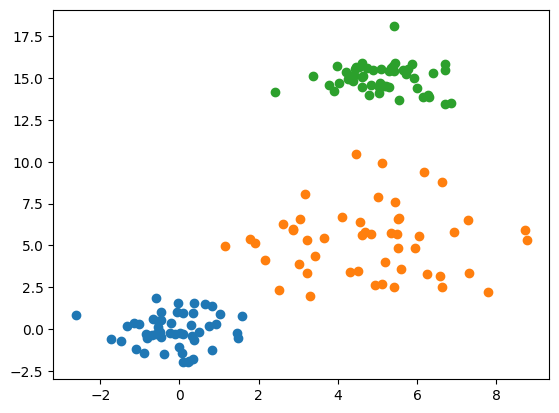

In [117]:
p1 = np.random.normal(loc=0, scale=1, size=(50,2))
p2 = np.random.normal(loc=5, scale=2, size=(50,2))
p3 = np.random.normal(loc=10, scale=0.8, size=(50,2)) - np.array([5, -5])

X = np.concatenate((p1, p2, p3))

plt.scatter(p1[:,0], p1[:, 1])
plt.scatter(p2[:,0], p2[:, 1])
plt.scatter(p3[:,0], p3[:, 1])

Нарисуем точки на плоскости, но без окрашивания точек. Так будет видеть данные алгоритм. Можем ли мы сами понять где и какие кластеры?

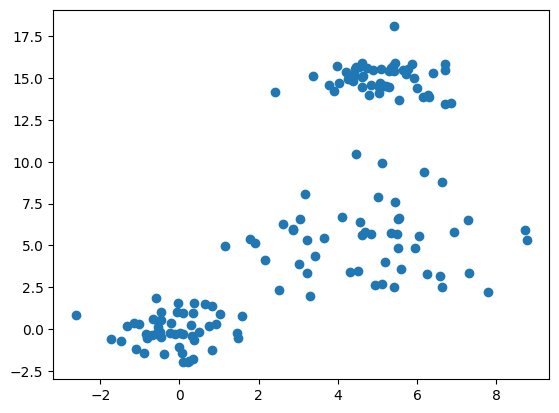

In [118]:
plt.scatter(X[:, 0], X[:, 1])

Рассмотрим пошагово работу алгоритма KMneans на основе обычного евклидова расстояния.  

_Пример из блога ODS: https://habrahabr.ru/company/ods/blog/325654/_

### 1.1 Напишите функцию, которая рассчитывает расстояния от центров кластеров до каждой точки и возвращает, к какому кластеру принадлежит каждая точка.

In [119]:
def kmeans_predict(x, clusters):
    labels = []
    
    for point in x:
        # Расчёт расстояния от точки до каждого центра кластера
        distances = [np.linalg.norm(point - center) for center in clusters]
        # Кластер с минимальным расстоянием
        labels.append(int(np.argmin(distances)))
    
    return np.array(labels)  

# В scipy есть замечательная функция, которая считает расстояния
# между парами точек из двух массивов, подающихся ей на вход
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html#scipy.spatial.distance.cdist
# Это сократит кол-во for и из-за этого код будет работать намного быстрее
# Но так нагляднее

Проверяем что получилось

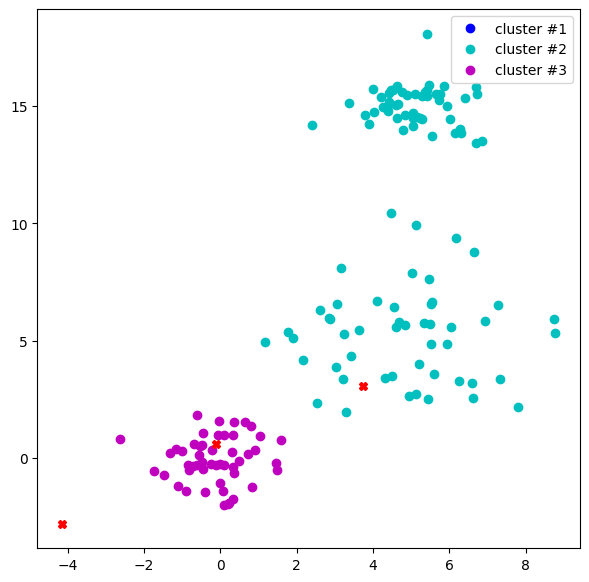

In [120]:
# Генерируем случайные координаты для центров кластеров
centroids = np.random.normal(loc=0.0, scale=5., size=6)
centroids = centroids.reshape((3, 2)) # итого получаем 3 точки в двумерном пространстве

plt.figure(figsize=(7, 7))
labels = kmeans_predict(X, centroids)

plt.plot(X[labels == 0, 0], X[labels == 0, 1], 'bo', label='cluster #1')
plt.plot(X[labels == 1, 0], X[labels == 1, 1], 'co', label='cluster #2')
plt.plot(X[labels == 2, 0], X[labels == 2, 1], 'mo', label='cluster #3')
plt.plot(centroids[:, 0], centroids[:, 1], 'rX')
plt.legend(loc=0)

### 1.2 Напишите код для обновления центров кластеров. Запоминайте центры кластеров $-$ это понадобится потом для визуализации.
Для упрощения каждому облачку данных заранее присвоим кластер.<br>
Положим в каждую новую центроиду геометрический центр её точек.<br>

In [121]:
centroids = np.random.normal(loc=0.0, scale=1., size=6).reshape((3, 2))

cent_history = [] # История центров кластеров
cent_history.append(centroids)

STEPS = 5 # количество шагов итерации обновления центров кластеров

for i in range(STEPS):
    # Присваиваем каждой точке метку ближайшего кластера
    labels = kmeans_predict(X, centroids)

    # Обновляем центроиды как среднее каждой группы
    for j in range(len(centroids)):
        points_in_cluster = X[labels == j]
        if len(points_in_cluster) > 0:
            centroids[j] = points_in_cluster.mean(axis=0)

    cent_history.append(centroids.copy())

А теперь нарисуем всю эту красоту

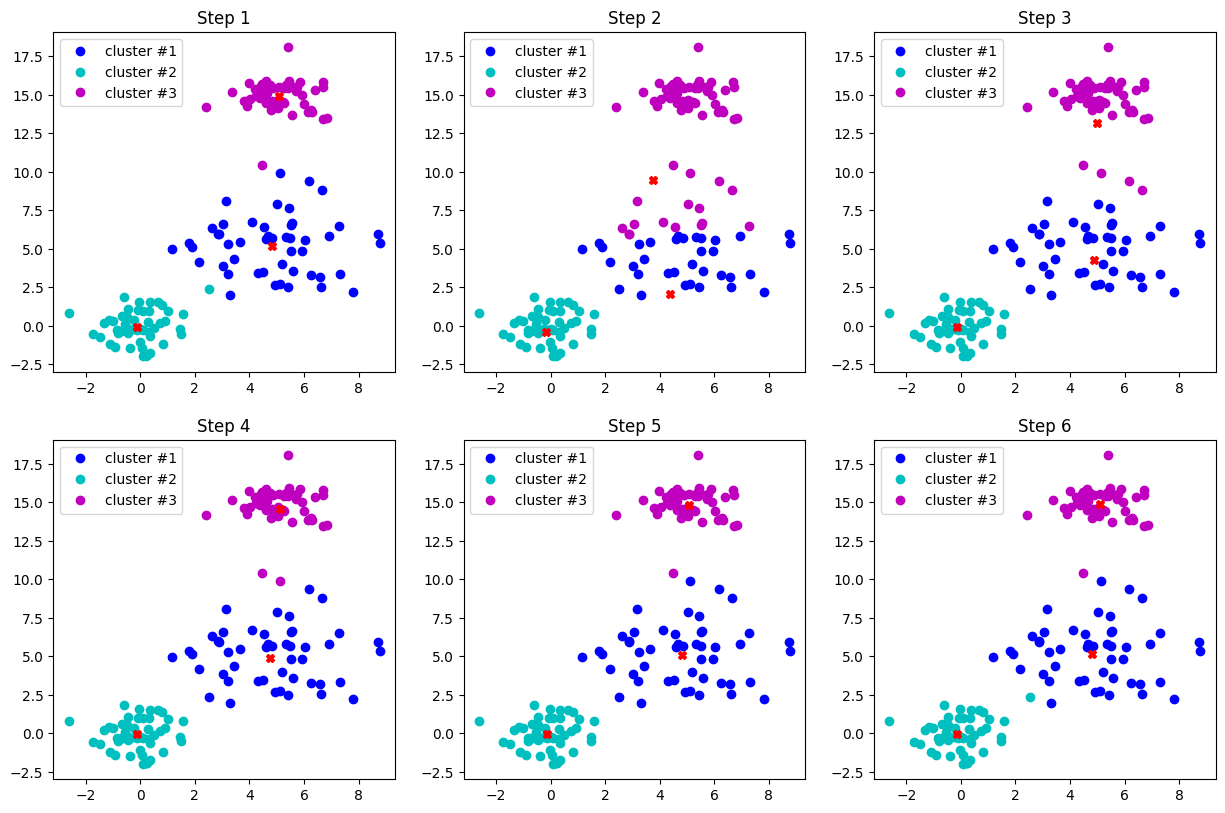

In [122]:
plt.figure(figsize=(15, 15))
for i in range(STEPS + 1):
    labels = kmeans_predict(X, cent_history[i])

    plt.subplot((STEPS + 1) // 2, (STEPS + 1) // 2, i + 1)
    plt.plot(X[labels == 0, 0], X[labels == 0, 1], 'bo', label='cluster #1')
    plt.plot(X[labels == 1, 0], X[labels == 1, 1], 'co', label='cluster #2')
    plt.plot(X[labels == 2, 0], X[labels == 2, 1], 'mo', label='cluster #3')
    plt.plot(cent_history[i][:, 0], cent_history[i][:, 1], 'rX')
    plt.legend(loc=0)
    plt.title('Step {:}'.format(i + 1));

Обратите внимание, последние 3 шага уже не сильно изменили координаты центров кластеров и состав кластеров.

### 1.3 Напишите функцию обучения kMeans, которая возвращает центры кластеров и к какому кластеру принадлежит каждая точка. 

* k - кол-во кластеров
* max_iter - через сколько итераций остановится
* tol - если сумма расстояний между прошлыми центрами кластеров и новыми центрами меньше tol, то остановится
* low и high - это минимально и максимально значение которое могут принимать точки центров кластеров при генерации

In [123]:
def kmeans_fit_predict(x, k=8, max_iter=100, tol=0.1, low=0.0, high=1.0):
    # Инициализация начальных центроид случайными значениями в диапазоне [low, high]
    centroids = np.random.uniform(low, high, size=(k, x.shape[1]))
    labels = np.zeros(x.shape[0], dtype=int)
    prev_centroids = centroids.copy()
    
    for i in range(max_iter):
        # Шаг 1: Присвоение меток (поиск ближайшего кластера для каждой точки)
        labels = np.array([np.argmin([np.linalg.norm(point - center) for center in centroids]) for point in x])
        
        # Шаг 2: Обновление центроид (геометрический центр каждой группы точек)
        for j in range(k):
            points_in_cluster = x[labels == j]
            if len(points_in_cluster) > 0:
                centroids[j] = points_in_cluster.mean(axis=0)
        
        # Проверка условия остановки
        shift = np.sum(np.linalg.norm(centroids - prev_centroids, axis=1))
        if shift < tol:
            break
        
        # Обновляем предыдущие центроиды
        prev_centroids = centroids.copy()
    
    return centroids, labels

## MNIST

Рассморим датасет рукописных цирф MNIST http://yann.lecun.com/exdb/mnist/

In [124]:
from sklearn import datasets

X, y = datasets.load_digits(return_X_y=True) # мы можем сразу же загрузить этот игрушечный датасет

print("Экземпляров: {}\nРазмер изображения: {}x{}".format(X.shape[0], np.sqrt(X.shape[1]), np.sqrt(X.shape[1])))

Экземпляров: 1797
Размер изображения: 8.0x8.0


#### 2.1 Выведите первые 10 экземпляров данных
###### Подсказка: используйте plt.subplot и reshape так как это картинки.

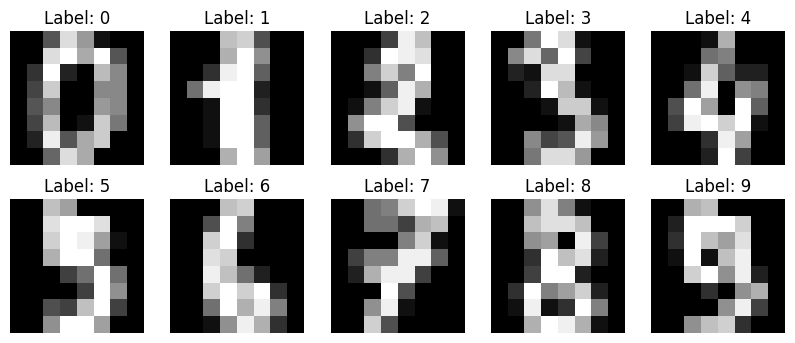

In [125]:
plt.figure(figsize=(10, 4))
for i in range(10):
    plt.subplot(2, 5, i + 1)  # сетка 2x5
    plt.imshow(X[i].reshape(8, 8), cmap='gray')  # преобразуем в 8x8 и показываем
    plt.title(f"Label: {y[i]}")
    plt.axis('off')  # убираем оси
plt.show()

Натренируем наш kMeans

In [126]:
clusters_mnist, labels_mnist = kmeans_fit_predict(X, k=10, low=0.0, high=np.max(X), tol=5)

Проверим. Выведем 10 точек из какого нибудь кластера и посмотрим, что они соотвествуют одной цифре.

8 8 8 8 8 8 8 8 8 8 

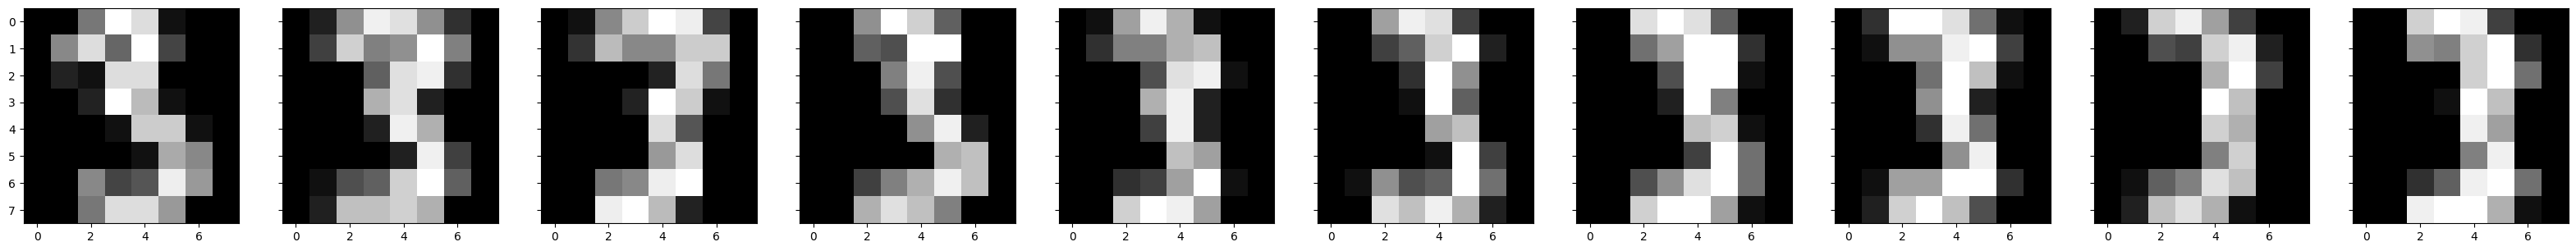

In [127]:
number = 3 # Номер кластера
count = 10 # Кол-во примеров
testX = X[y == number]

testX[0,:].reshape([8,8])
f, axes = plt.subplots(1, count, sharey=True, figsize=(40,6))
for i in range(count):
    print(labels_mnist[y == number][i], end=' ')
    axes[i].imshow(testX[i,:].reshape([8,8]), cmap='gray')

## Центры кластеров фотографий

Можно найти центры кластеров по фотографиям людей....

In [128]:
# загрузим датасет с фотографиями знаменитостей
from sklearn import datasets
lfw_people = datasets.fetch_lfw_people(min_faces_per_person=50, resize=0.4)

George W Bush: 530 photos.
Gerhard Schroeder: 109 photos.


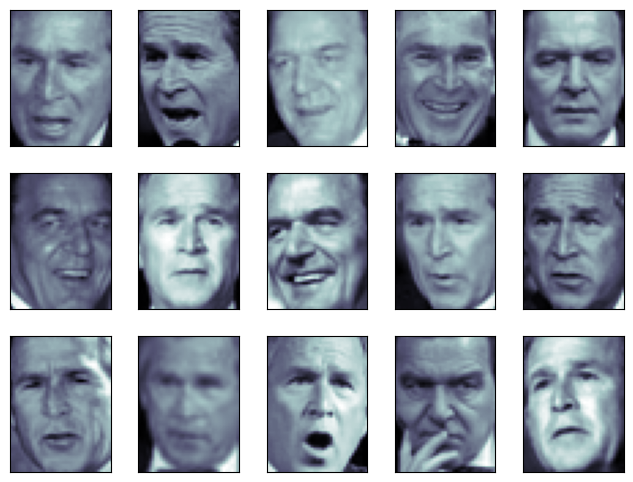

In [129]:
fig = plt.figure(figsize=(8, 6))

for i in range(15):
    ax = fig.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(lfw_people.images[i], cmap='bone')

for i, name in enumerate(lfw_people.target_names):
    print("{}: {} photos.".format(name, (lfw_people.target == i).sum()))

### 3.1 Натренируйте kMeans и нарисуйте центры кластеров как картинки выше.

In [130]:
from sklearn.cluster import KMeans

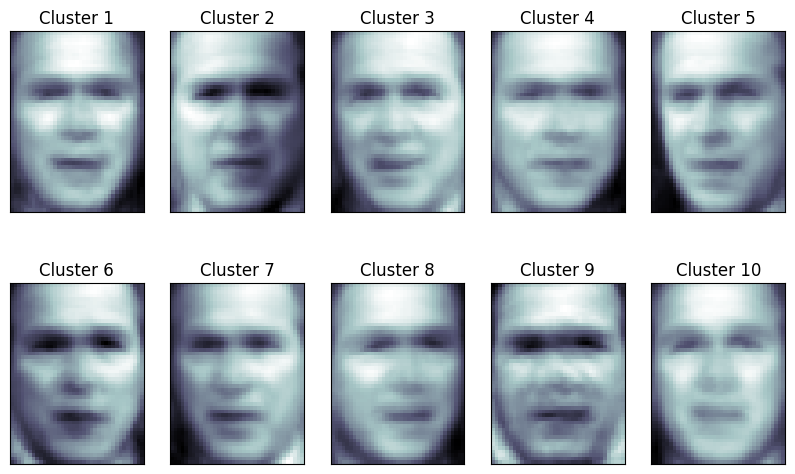

In [131]:
X = lfw_people.data 
n_clusters = 10  # кол-во кластеров для KMeans

# kMeans
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
kmeans.fit(X)

# центроиды кластеров
centroids = kmeans.cluster_centers_

# Визуализация центроид как изображений
fig = plt.figure(figsize=(10, 6))
for i in range(n_clusters):
    ax = fig.add_subplot(2, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(centroids[i].reshape(lfw_people.images.shape[1], lfw_people.images.shape[2]), cmap='bone')
    ax.set_title(f"Cluster {i + 1}")
plt.show()

## Птичка 

С помощью алгоритмов кластеризации можно уменьшить число цветов в изображении. В данном случае будут кластеризоваться похожие пиксели. Такой подход позволяет перейти к суперпиксельному представлению изображений, которое является более компактным и используется в задачах компьютерного зрения.

Загрузим картинку `data/bird.jpg` с помощью scikit-image и выведем ее с помощью matplotlib.

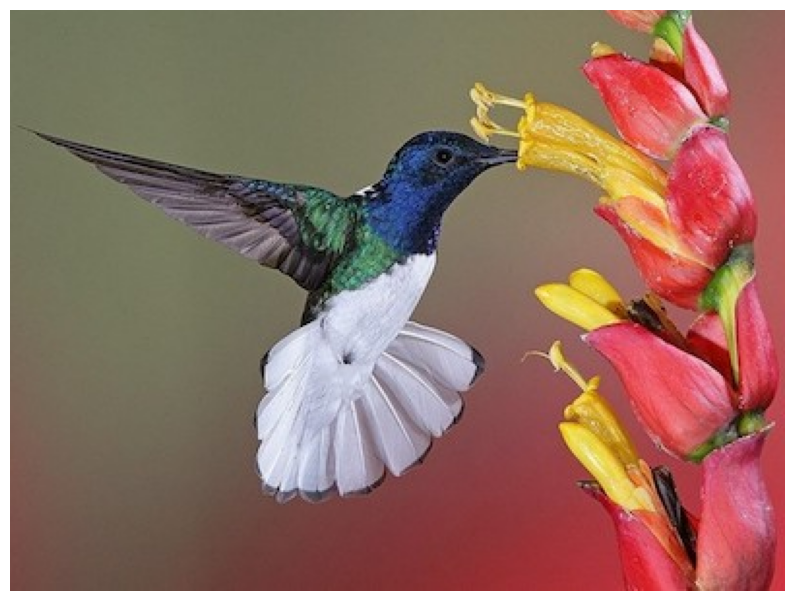

In [132]:
%matplotlib inline
from skimage.io import imread
from matplotlib import pyplot as plt
import numpy as np

img = imread("../data/bird.jpg")
plt.figure(figsize=(10,15))
plt.axis('off')
plt.imshow(img)

### 4.1 Scale 

Если вы посмотрите на содержимое numpy-массива, в котором хранится изображение, то увидите, что там будут числа от 0 до 255. Нам лучше перейти к числам от 0 до 1. 

**Преобразуйте вашу матрицу, как сказано выше.**

**Hint**: Это можно сделать с помощью функции `skimage.img_as_float`.

In [133]:
from skimage import img_as_float

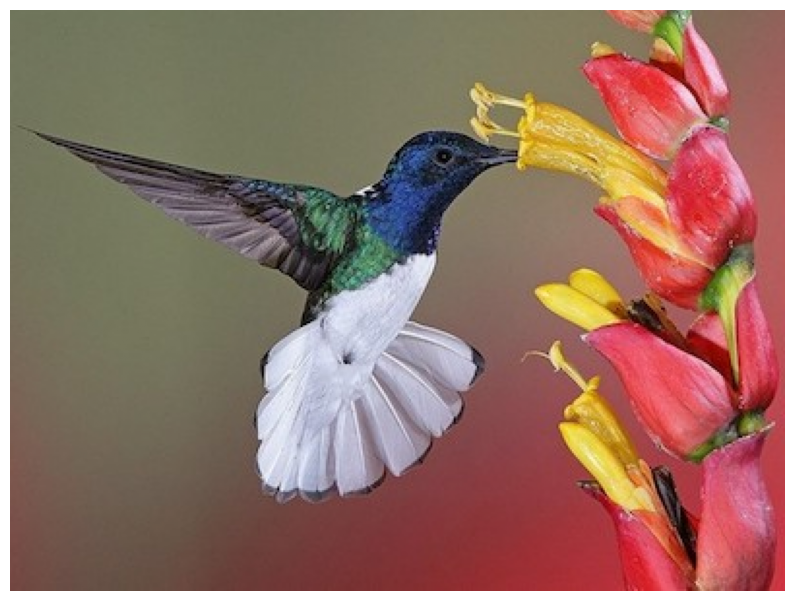

In [134]:
img_float = img_as_float(img)

plt.figure(figsize=(10, 15))
plt.axis('off')
plt.imshow(img_float)
plt.show()

### 4.2 Reshape 

Мы получили матрицу размера `(300, 400, 3)`. Нам это не подходит. Чтобы запустить kMeans нам нужно иметь много-много объектов и 3 признака - значение яркости пикселя в канале Red, Green и Blue. 

**Преобразуйте матрицу так, чтобы получилась матрица размера `(120000, 3)`. **

**Hint**: Вам пригодятся функции: `np.ravel` и `np.vstack`.

In [135]:
r = img_float[:, :, 0].ravel()
g = img_float[:, :, 1].ravel()
b = img_float[:, :, 2].ravel()

pixels = np.vstack((r, g, b)).T

# Вроде код ниже работает аналогично
# pixels = img_float.reshape(-1, 3)

### 4.3 Train 

Отлично. У нас есть подготовленные данные. Теперь мы будем находить кластеры похожих пикселей по цвету. Для этого создайте KMeans для, например, 8 цветов. **Обучите модель** (может занять около 10 секунд). С помощью магического макроса `%time` **покажите, сколько времени у вас занимало обучение**.

In [136]:
# кол-во кластеров (цветов)
n_colors = 12
kmeans = KMeans(n_clusters=n_colors, random_state=0)
%time kmeans.fit(pixels)

CPU times: total: 188 ms
Wall time: 131 ms


KMeans(n_clusters=12, random_state=0)

### 4.4 Draw centroids 

**Нарисуйте с помощью imshow центры кластеров**: будет 8 пикселей со средним цветом по всему кластеру. 
Это называется цветовой палитрой. 

**Hint**: reshape в 3 мерный массив, так как у вас будет 2-мерный

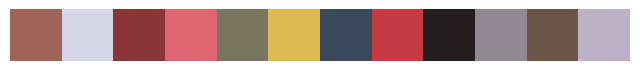

In [137]:
palette = kmeans.cluster_centers_

# Преобразуем центроиды в 3-мерный массив (1, n_colors, 3) для отображения
palette_image = palette.reshape(1, -1, 3)

# Визуализация
plt.figure(figsize=(8, 2))
plt.axis('off')
plt.imshow(palette_image)
plt.show()

### 4.5 Draw final image 

У нас есть значения цвета для каждого центра кластера. Каждый пиксель в результате обучения KMeans теперь имеет свой лейбл кластера. Значит мы можем заменить все пиксели на соответсвующие им центры класетров. Проведите это преобразование и выведите 8-цветное изображение.

**Hints**: `labels_`, `reshape`, `copy`, логические маски в numpy `arr[arr == 1] = 0`. У меня это 7 строк кода.

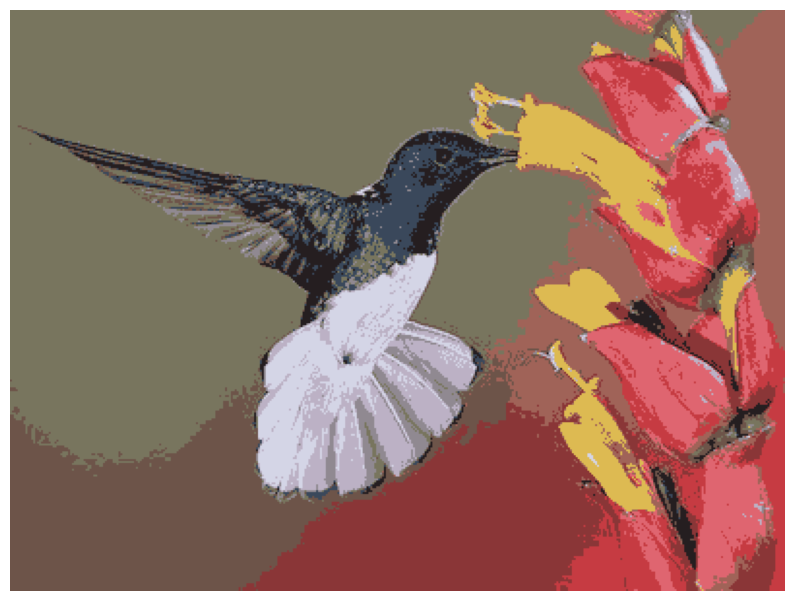

In [138]:
labels = kmeans.labels_
segmented_img = palette[labels].copy()
segmented_img = segmented_img.reshape(img.shape)

# Отображаем сегментированное изображение
plt.figure(figsize=(10, 15))
plt.axis('off')
plt.imshow(segmented_img)
plt.show()

# Далее - оригинальный нерабочий код

## Визуализация 64-мерного пространства, используя PCA и TSNE

Просто так визуализировать 64-мерный объект не получится, нам нужно уменьшить его размерность до 2, чтобы он укладывался на плоскость.

Существует специальный алгоритм PCA - Метод главных компонент.

![](http://scikit-learn.org/stable/_static/scikit-learn-logo-small.png)

Далее мы будем использовать библиотеку [scikit-learn](http://scikit-learn.org/). По сути это библиотека-набор разных алгоритмов анализа данных, машинного обучения.

Документация по библиотеке всегда доступна:
- по ? в jupyter
- по комбинации shift-tab в jupyter
- на сайте http://scikit-learn.org/stable/documentation.html

Просто так визуализировать 64-мерный объект не получится, нам нужно уменьшить его размерность до 2, чтобы он укладывался на плоскость.

Существует специальный алгоритм PCA -  [Метод главных компонент](https://ru.wikipedia.org/wiki/%D0%9C%D0%B5%D1%82%D0%BE%D0%B4_%D0%B3%D0%BB%D0%B0%D0%B2%D0%BD%D1%8B%D1%85_%D0%BA%D0%BE%D0%BC%D0%BF%D0%BE%D0%BD%D0%B5%D0%BD%D1%82).

Нарисуем scatter plot для тренировочной выборки: на графике у нас будут точки, помеченные лейблом - цифрой которую обозначает эта точка в пространстве.

C:\Users\Simon\AppData\Local\Temp\ipykernel_33592\3898024138.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  plt.scatter(X_reduced[:,0], X_reduced[:,1], c=y, cmap=plt.cm.get_cmap('nipy_spectral', 10),


ValueError: 'c' argument has 1797 elements, which is inconsistent with 'x' and 'y' with size 639.

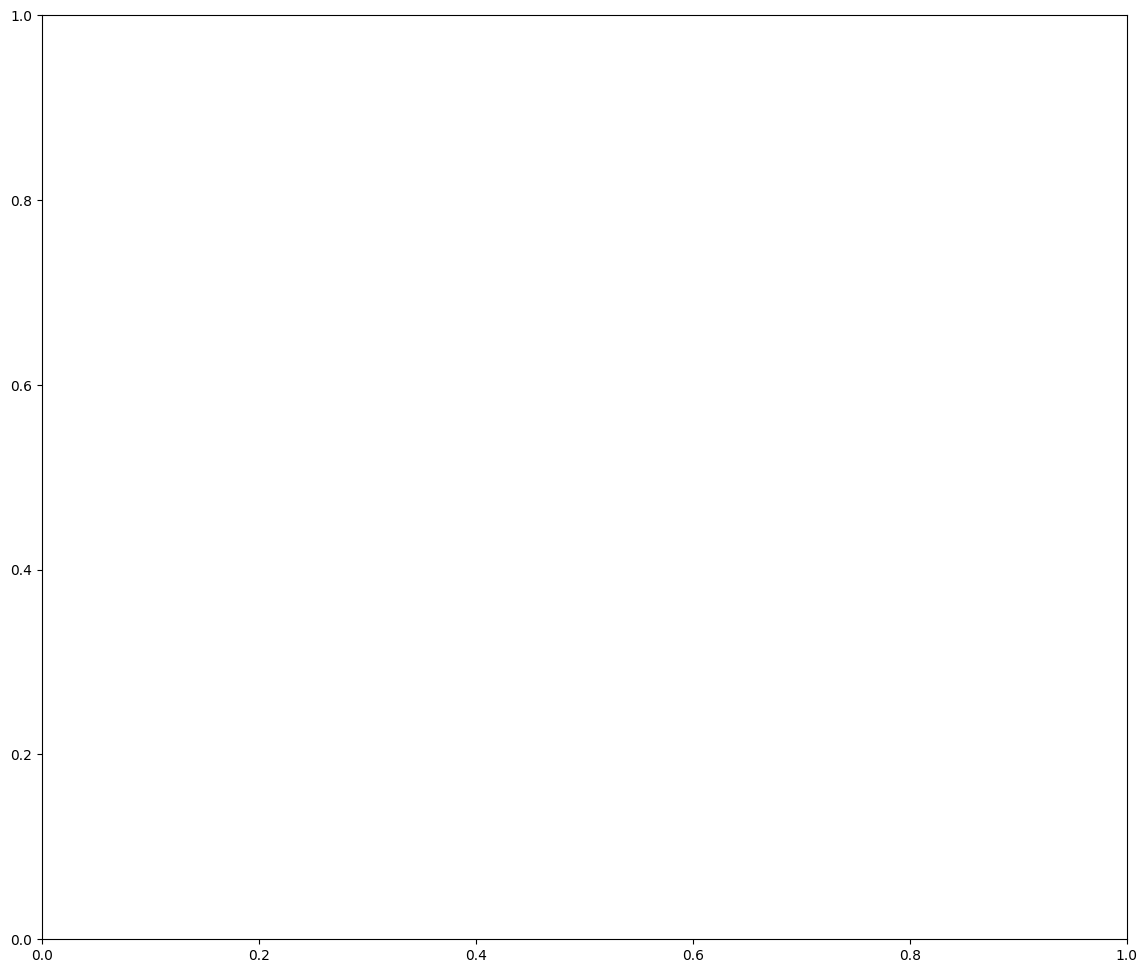

In [139]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=42) # 2 компоненты, значит 2-мерное представление

X_reduced = pca.fit_transform(X)
plt.figure(figsize=(14,12))
plt.scatter(X_reduced[:,0], X_reduced[:,1], c=y, cmap=plt.cm.get_cmap('nipy_spectral', 10),
            edgecolor='none', alpha=0.8, s=30,)
plt.colorbar()


А теперь посмотрим как расставил границы наш алгоритм KMeans. Как видим - хоть цвета и перепутаны, но сами кластеры угадываются.

In [90]:
plt.figure(figsize=(14,12))
plt.scatter(X_reduced[:,0], X_reduced[:,1], c=clf.labels_, cmap=plt.cm.get_cmap('nipy_spectral', 10),
            edgecolor='none', alpha=0.8, s=30,)
plt.colorbar()

NameError: name 'clf' is not defined

<Figure size 1400x1200 with 0 Axes>

Центры кластеров представляют из себя нечто среднее, окруженное максимально "похожими" на них элементами. Поэтому мы можем предположить, что на визуализации, центры кластеров будут похожи на цифры.

Центры кластеров можно получить у модели `clf.cluster_centers_`.

In [ ]:
plt.figure(figsize=(16, 6))

for i, center in enumerate(clf.cluster_centers_):
    plt.subplot(2, 5, i + 1)
    plt.imshow(center[:].reshape([8,8]), cmap='gray')

Существуют и другие методы понижения размерности, например t-SNE, но он намного медленнее чем PCA.

Мы пока что не изучаем как именно работают PCA и tSNE, просто восхтимся их способностями.

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, init='pca', random_state=42)
X_reduced_t = tsne.fit_transform(X)

plt.figure(figsize=(14,12))
plt.scatter(X_reduced_t[:,0], X_reduced_t[:,1], c=y, cmap=plt.cm.get_cmap('nipy_spectral', 10),
            edgecolor='none', alpha=0.8, s=30,)
plt.colorbar()

Теперь нарисуем тот же scatter-plot, только на основе лейблов из kMeans. Ожидаем что кластеры будут покрашены в нужные цвета.

In [ ]:
plt.figure(figsize=(14,12))
plt.scatter(X_reduced_t[:,0], X_reduced_t[:,1], c=clf.labels_, cmap=plt.cm.get_cmap('nipy_spectral', 10),
            edgecolor='none', alpha=0.8, s=30,)
plt.colorbar()

## Бонусная секция

## Playboy

Анализ изменений стандартов красоты девушек на основе статистики журнала Playboy за последние 55 лет.

Мы с вами проверим, можно ли с помощью KMeans определить кластеры по размерам и соотнести их с годом.

In [141]:
data = pd.read_csv('../data/girls.csv')
data.head()

,Month,Year,Bust,Waist,Hips,Height,Weight
0,December,1953,91,61,91,165,54
1,March,1954,86,61,89,168,54
2,July,1955,91,61,91,166,52
3,December,1955,91,61,91,166,52
4,July,1956,91,61,86,157,48


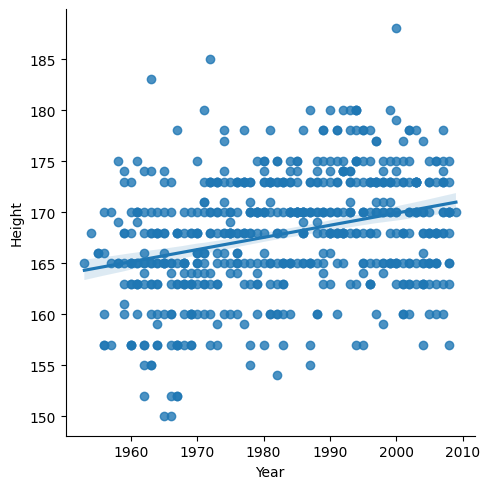

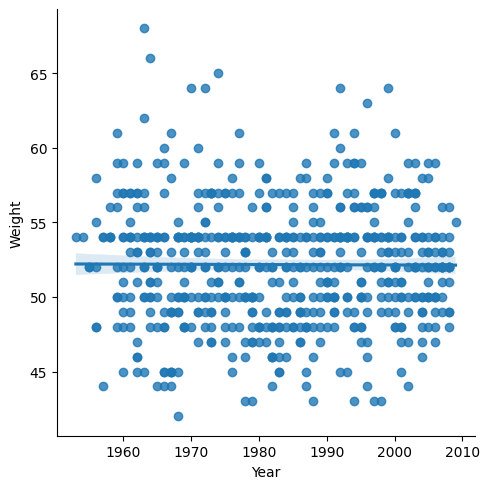

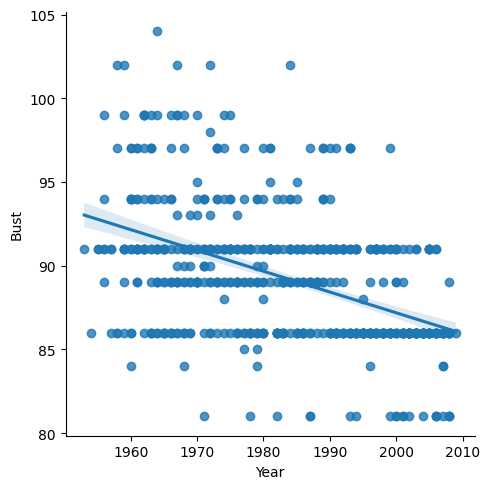

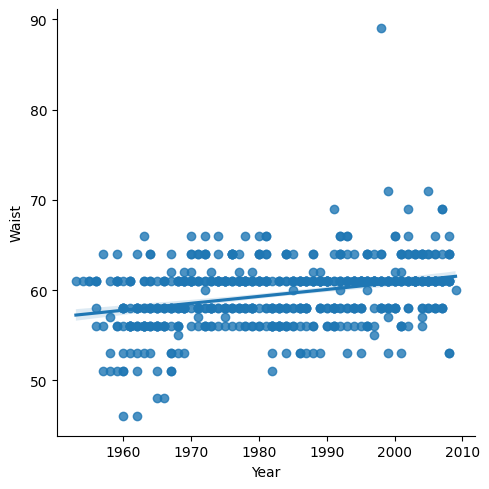

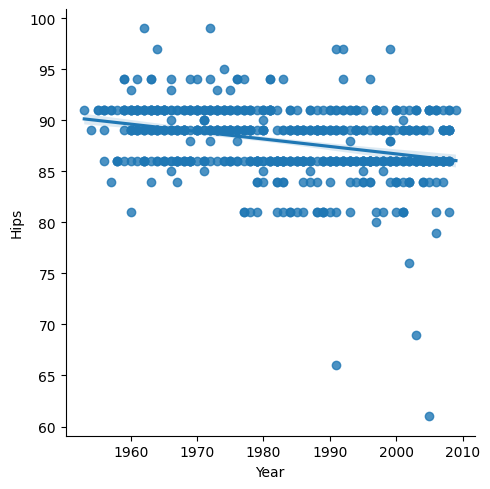

In [142]:
sns.lmplot(x='Year', y='Height', data=data)
sns.lmplot(x='Year', y='Weight', data=data)
sns.lmplot(x='Year', y='Bust',   data=data)
sns.lmplot(x='Year', y='Waist',  data=data)
sns.lmplot(x='Year', y='Hips',   data=data)

Вывод:

|Метрика|Изменение|
|-------|
|Рост|+|
|Вес|=|
|Грудь|-|
|Талия|=|
|Бедра|-|

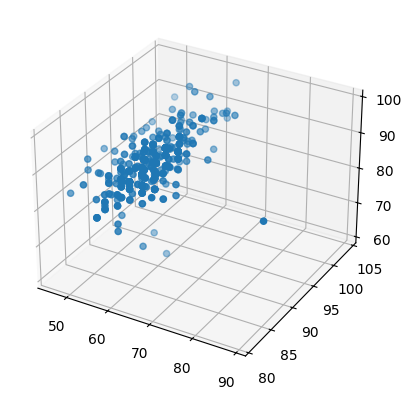

In [143]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data['Waist'], data['Bust'], data['Hips'])

Ничего не видно на триде графике. Нужно спроецировать его на плоскость каким-то хитрым способом. 

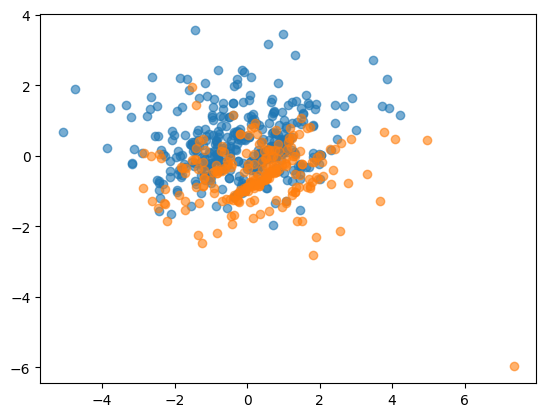

In [144]:
from sklearn.decomposition import PCA  # инструмент понижения размерности
from sklearn.preprocessing import RobustScaler  # нормализация признаков

pca = PCA(n_components=2)
s = RobustScaler()
p = pca.fit_transform(s.fit_transform(data[['Bust','Waist','Hips', 'Height', 'Weight']]))

data['px'] = p[:,0]
data['py'] = p[:,1]

date = 1990
old = data[data['Year'] < date]
new = data[data['Year'] >= date]
plt.scatter(old['px'], old['py'], alpha=0.6)
plt.scatter(new['px'], new['py'], alpha=0.6)

4


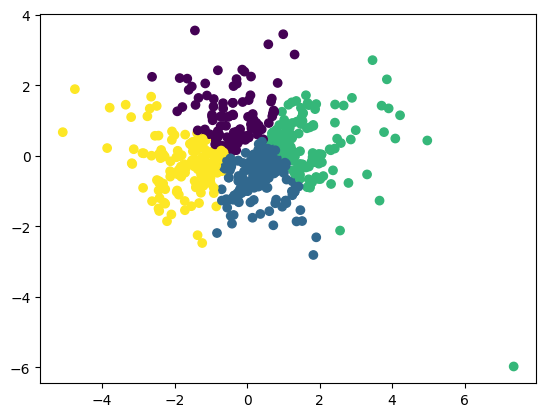

In [145]:
from sklearn.cluster import KMeans

clf = KMeans(n_clusters=4)
x = data[['Bust','Waist','Hips', 'Height', 'Weight']]
clf.fit(s.fit_transform(x))

data['label'] = clf.labels_
plt.scatter(data['px'], data['py'], c=clf.labels_)
print(len(set(clf.labels_)))

C:\Users\Simon\AppData\Local\Temp\ipykernel_33592\1717744941.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data[data['label'] == i]['Year'],hist=False)
C:\Users\Simon\AppData\Local\Temp\ipykernel_33592\1717744941.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data[da

,Bust,Waist,Hips,Height,Weight
label,,,,,
0,92.376147,56.816514,89.614679,167.752294,53.082569
1,87.460000,61.205000,87.400000,168.270000,51.995000
2,91.992857,62.892857,90.728571,172.457143,56.514286
3,87.051613,56.238710,84.948387,163.361290,47.825806


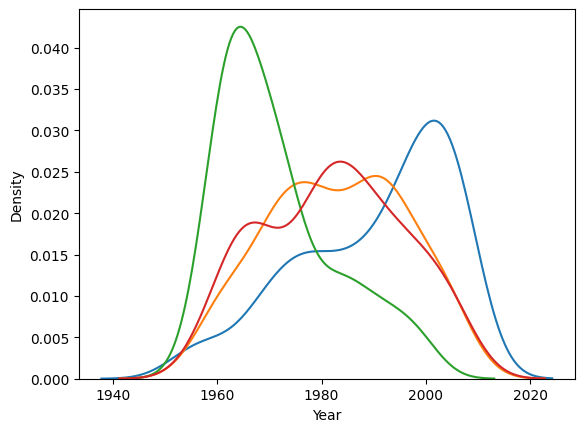

In [146]:
for i in data['label'].unique():
    sns.distplot(data[data['label'] == i]['Year'],hist=False)
data.groupby('label')[['Bust', 'Waist', 'Hips', 'Height', 'Weight']].mean()